In [1]:
import nasdaqdatalink as quandl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta
from common import date_util
from data import investment_universe, sharadar_fundamentals, sharadar_prices, sharadar_tickers
from signals import fundamental_signal

In [2]:
quandl.ApiConfig.api_key = 'NRvcyMwNMXZ2ooDSM3nw'
factor_summary = {}

In [3]:
factor = "cfroi"
pnl = []
sector_level_pnl = {}
dates = []
for i in range(1999, 2020):
    for j in range(1, 13):    
        as_of_date = date_util.get_bus_month_end(i, j)
        dates.append(as_of_date)
        universe = investment_universe.get_SPX(as_of_date)
        fundamentals = sharadar_fundamentals.get_fundamentals(universe['ticker'].to_list(), as_of_date, "ART")
        prices = sharadar_prices.get_prices(universe['ticker'].to_list(), as_of_date)
        price_df = prices[["ticker", "forward_return"]]
        sectors = sharadar_tickers.get_tickers(universe['ticker'].to_list(), as_of_date)
        sectors = sectors[["ticker", "sector"]]
        # pq_fundamentals = sharadar_fundamentals.get_fundamentals(universe['ticker'].to_list(), date_util.get_bus_month_end((as_of_date - timedelta(days=380)).year, (as_of_date - timedelta(days=380)).month), "ART")

        fundamentals = pd.merge(fundamentals, sectors, left_on="ticker", right_on="ticker", how="inner")
        fundamentals = pd.merge(fundamentals, price_df, left_on="ticker", right_on="ticker", how="inner")
        fundamentals.loc[fundamentals["sector"] == "Real Estate", "sector"] = "Financial Services"
        # fundamentals = pd.merge(fundamentals, pq_fundamentals, left_on="ticker", right_on="ticker", how="inner", suffixes=["", "_p"])

        # fundamentals["efficiency"] = (fundamentals["revenue_p"] - fundamentals["cor_p"]) / fundamentals["assets_p"] - (fundamentals["revenue"] - fundamentals["cor"]) / fundamentals["assets"]
        fundamentals = fundamental_signal.cfroi(fundamentals)
        # fundamentals = fundamental_signal.fcf_to_ev(fundamentals)
        fundamentals["composite"] = fundamentals.groupby("sector", group_keys=False)["cfroi"].apply(lambda x: (x - np.mean(x)) / np.std(x))

        fundamentals = fundamentals.sort_values("composite", ascending=False)
        fundamentals = fundamentals[~fundamentals["composite"].isna()]
        # fundamentals = fundamentals[~fundamentals["sector"].isin(["Financial Services", "Real Estate"])]
        pnl.append(fundamentals[fundamentals["composite"] >= fundamentals.groupby("sector")["composite"].transform("quantile", 0.8)]["forward_return"].mean() - 
                   fundamentals[fundamentals["composite"] <= fundamentals.groupby("sector")["composite"].transform("quantile", 0.2)]["forward_return"].mean())
        longs = fundamentals[fundamentals["composite"] >= fundamentals.groupby("sector")["composite"].transform("quantile", 0.8)].groupby("sector").agg({"forward_return": "sum", "ticker": "count"})
        shorts = fundamentals[fundamentals["composite"] <= fundamentals.groupby("sector")["composite"].transform("quantile", 0.2)].groupby("sector").agg({"forward_return": "sum", "ticker": "count"})
        sector_pnl = pd.merge(longs, shorts, left_index=True, right_index=True, suffixes=["_l", "_s"])
        sector_pnl["forward_return"] = sector_pnl["forward_return_l"] / sector_pnl["ticker_l"] - sector_pnl["forward_return_s"] / sector_pnl["ticker_s"]
        sector_level_pnl[as_of_date] = sector_pnl["forward_return"].to_list()
sector_level_pnl_df = pd.DataFrame.from_dict(sector_level_pnl, orient='index')
factor_array = []
pnl = np.array(pnl)
factor_array.append(np.mean(pnl) * 12)
factor_array.append(np.std(pnl) * np.sqrt(12))
factor_array.append(np.mean(pnl) / np.std(pnl) * np.sqrt(12))
cum_returns = np.cumprod(pnl + 1) - 1
high_watermark = np.maximum.accumulate(cum_returns)
drawdown = high_watermark - cum_returns
factor_array.append(np.max(drawdown))
factor_array.append(len(pnl[pnl >= 0]) / len(pnl))
factor_array.append(np.mean(pnl[pnl >= 0]))
factor_array.append(np.mean(pnl[pnl < 0]))
factor_array.append(np.max(pnl))
factor_array.append(np.min(pnl))
factor_array.append(np.mean(pnl[:120]) * 12)
factor_array.append(np.std(pnl[:120]) * np.sqrt(12))
factor_array.append(np.mean(pnl[:120]) / np.std(pnl[:120]) * np.sqrt(12))
factor_array.append(np.mean(pnl[120:]) * 12)
factor_array.append(np.std(pnl[120:]) * np.sqrt(12))
factor_array.append(np.mean(pnl[120:]) / np.std(pnl[120:]) * np.sqrt(12))
factor_array.extend(sector_level_pnl_df.sum(axis=0).to_list())
factor_summary[factor] = factor_array

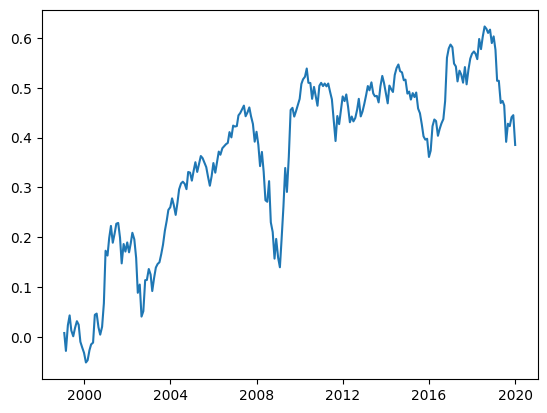

In [16]:
plt.plot(dates, (np.cumprod(pnl + 1) - 1))

In [17]:
fundamentals.shape

(485, 118)

In [18]:
factor_array

[0.01839171300981523,
 0.07590632966605786,
 0.2422948532846693,
 0.3246366868406012,
 0.5476190476190477,
 0.016420728732152032,
 -0.016489777121323337,
 0.09913504696073348,
 -0.06295203525886846,
 0.018209850721620305,
 0.08315965797711858,
 0.21897457450619565,
 0.01855704236271971,
 0.06865053054456231,
 0.27031171085668443,
 1.734593541008563,
 1.2214050746949467,
 0.027555809283471983,
 0.09432228705743534,
 -0.6201506340111833,
 -0.2833263972412694,
 1.6801450807447946,
 0.40526047551955213,
 1.1801617105381672,
 -0.9065565507975988]

In [19]:
fundamentals[fundamentals["cfroi"] == 0]

,None,ticker,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,...,taxexp,taxliabilities,tbvps,workingcapital,sector,forward_return,non_depre_assets,cfroi,cf,composite


In [20]:
fundamentals.sort_values("cfroi", ascending=False).loc[:, ["ticker", "price", "fcfps", "eps", "dps", "non_depre_assets", "sharefactor", "marketcap", "shareswa", "investments", "intangibles", "ppnenet", "tbvps", "sector", "cfroi"]]

,ticker,price,fcfps,eps,dps,non_depre_assets,sharefactor,marketcap,shareswa,investments,intangibles,ppnenet,tbvps,sector,cfroi
428,BMY,57.37,4.654,3.47,1.640,23.022372,1.0,93472068861,1629284798,2978000000,7515000000,4830000000,30.638,Healthcare,0.296241
92,SIVBQ,238.68,17.227,21.82,0.000,1153.987870,1.0,12308252627,51568010,59183613000,190111000,325245000,1319.444,Financial Services,0.289030
434,BFH,103.65,42.828,8.50,2.460,659.539809,1.0,4773725545,48800000,16862400000,1111700000,542000000,533.732,Financial Services,0.254956
122,PRU,92.05,67.254,9.47,3.900,1302.248756,1.0,37004100000,402000000,523504000000,0,0,2203.050,Financial Services,0.228650
195,MET,48.38,10.772,7.52,1.740,513.132841,1.0,44491760214,919631257,471893000000,9278000000,0,797.639,Financial Services,0.219235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,DD,65.91,3.360,1.06,3.000,20.936635,1.0,48826570717,745500000,1739000000,46704000000,9699000000,31.408,Basic Materials,-0.597924
269,HSY,143.31,6.605,5.70,2.939,7.144630,1.0,29940522824,208921379,0,3435088000,2099985000,24.072,Consumer Defensive,-0.612386
497,A,84.51,2.758,3.41,0.656,6.644456,1.0,26213600402,314000000,102000000,4700000000,850000000,15.134,Healthcare,-0.736410
486,ADP,161.88,5.567,5.47,3.160,11.841513,1.0,70045166647,432700000,3545100000,3382200000,1271100000,79.345,Industrials,-0.739843


In [21]:
pd.DataFrame.from_dict(factor_summary, orient='index').to_csv("factor_summary.csv")

In [22]:
fundamentals[fundamentals["composite"] >= fundamentals.groupby("sector")["composite"].transform("quantile", 0.8)].groupby("sector").agg({"forward_return": "sum", "ticker": "count"})

,forward_return,ticker
sector,,
Basic Materials,-0.293329,5
Communication Services,0.046411,5
Consumer Cyclical,-0.497592,12
Consumer Defensive,-0.521960,8
Energy,-0.671939,6
Financial Services,-1.218196,20
Healthcare,-0.622366,12
Industrials,-0.748695,14
Technology,-0.162619,13


In [23]:
fundamentals[fundamentals["composite"] <= fundamentals.groupby("sector")["composite"].transform("quantile", 0.2)].groupby("sector").agg({"forward_return": "sum", "ticker": "count"})

,forward_return,ticker
sector,,
Basic Materials,-0.236783,5
Communication Services,-0.095387,5
Consumer Cyclical,-0.056856,12
Consumer Defensive,0.162675,8
Energy,-0.892947,6
Financial Services,0.548481,20
Healthcare,-0.025823,12
Industrials,0.274049,14
Technology,-0.228204,13


In [12]:
sector_level_pnl_df = pd.DataFrame.from_dict(sector_level_pnl, orient='index')

In [13]:
sector_level_pnl_df.head()

,0,1,2,3,4,5,6,7,8,9
1999-01-29,0.110339,-0.079160,-0.029389,-0.002932,-0.007766,0.054533,-0.014987,-0.035527,0.057636,-0.028518
1999-02-26,-0.025276,-0.059317,-0.040061,-0.032689,-0.078740,0.026352,0.000907,-0.066941,-0.073225,-0.055942
1999-03-31,0.117001,0.025793,0.062368,0.016078,0.025395,-0.018202,0.136176,0.097097,0.042635,0.034539
1999-04-30,-0.059347,0.027934,0.065179,0.046389,0.092008,0.044701,0.034788,0.036059,-0.081218,-0.012867
1999-05-28,0.066035,-0.015042,-0.065620,-0.050313,-0.000736,-0.016710,-0.071578,-0.062135,-0.023400,-0.023623


In [14]:
sector_level_pnl_df.cumsum(axis=0)

,0,1,2,3,4,5,6,7,8,9
1999-01-29,0.110339,-0.079160,-0.029389,-0.002932,-0.007766,0.054533,-0.014987,-0.035527,0.057636,-0.028518
1999-02-26,0.085063,-0.138477,-0.069450,-0.035620,-0.086505,0.080885,-0.014080,-0.102467,-0.015590,-0.084459
1999-03-31,0.202064,-0.112684,-0.007081,-0.019542,-0.061111,0.062683,0.122097,-0.005370,0.027045,-0.049921
1999-04-30,0.142717,-0.084751,0.058097,0.026847,0.030897,0.107384,0.156884,0.030688,-0.054173,-0.062787
1999-05-28,0.208752,-0.099793,-0.007522,-0.023467,0.030162,0.090674,0.085306,-0.031447,-0.077573,-0.086410
...,...,...,...,...,...,...,...,...,...,...
2019-08-30,1.691280,1.125782,0.083776,0.152940,-0.612477,-0.211087,1.682502,0.511609,1.126863,-0.877503
2019-09-30,1.720087,1.126559,0.049634,0.146267,-0.665732,-0.226677,1.695157,0.510606,1.186439,-0.919489
2019-10-31,1.727512,1.208971,0.052914,0.169219,-0.620170,-0.199475,1.718701,0.469833,1.191156,-0.918827
2019-11-29,1.745903,1.193045,0.064284,0.179902,-0.656985,-0.194993,1.729857,0.478314,1.175117,-0.899142


In [15]:
sector_level_pnl_df.sum(axis=0).to_list()

[1.734593541008563,
 1.2214050746949467,
 0.027555809283471983,
 0.09432228705743534,
 -0.6201506340111833,
 -0.2833263972412694,
 1.6801450807447946,
 0.40526047551955213,
 1.1801617105381672,
 -0.9065565507975988]